In [175]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow import keras

#Tools for balancing data
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

#Tools for building neural networks
from keras.models import Sequential
from keras.layers import Conv2D

#Tools for processing the images
from skimage import color
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from skimage.filters import try_all_threshold

#Tools for preparing train, test, and validation sets
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



#Seperate file containing custom functions
from my_functions import * 

# Preparing the Training, Testing, and Validation Sets

In this step we will split the dataset into a training and a testing set, and split the training set again into a training and validation set.

In [176]:
#Import the data
my_data = pd.read_csv('kuzushiji_raw.csv')

#Convert the unicode labels to integers so we can use them with our classifier
labels = my_data['Unicode']
labels = labels.values.tolist()
label_encoder = LabelEncoder()
Y = np.array(label_encoder.fit_transform(labels))

#Create a training and testing set
x_train, x_test, y_train, y_test = train_test_split(my_data['File'], Y,random_state=42,train_size=0.001)


#Convert the pandas series to lists
x_train = x_train.tolist()
y_train = y_train.tolist()
x_val = x_val.tolist()
y_val = y_val.tolist()

#Examine the size of each set
print("The training set has "+ str(len(x_train))+" observations")
#print("The validation set has "+ str(len(x_val))+" observations")
print("The test set has "+ str(len(x_test))+" observations")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The training set has 1086 observations
The test set has 1085240 observations


At the moment, the training, test, and validation sets only contain lists of file names rather than the images themselves

In [177]:
print(x_train[3])
#print(x_val[33])
print(x_test[333])

./all/100249371/characters/U+308A/U+308A_100249371_00010_1_X0849_Y0728.jpg
./all/200019865/characters/U+30CF/U+30CF_200019865_00077_2_X0838_Y2054.jpg


# Examining the Images

The Kuzushiji data set consists of both full pages from the books, as well as images of the individual characters on each page. Here is a sample image of a full page.

In [178]:
#Load a sample image and store the file's stem
file = Path("all/100241706/images/100241706_00004_2.jpg")
stem = Path("all/100241706/images/100241706_00004_2.jpg").stem

img = plt.imread(file)
show_image(img)

NameError: name 'Path' is not defined

However, we will be using the images of the individual characters for our classifier.

In the next step, we will load the images using the file names we have stored. In order to use the images with neural networks, we will convert them from RGB into grayscale and resize them so they are all the same size (in this case 224 by 224 pixels).

In [179]:
img_size = 224

#Load all of the images, convert them to grayscale and resize them all to 224 by 224.
x_train = process_images(x_train,img_size)
#x_val = process_images(x_val,img_size)


Here is a sample image from the original file source and a sample image after it has been processed

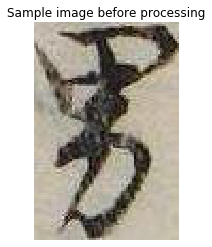

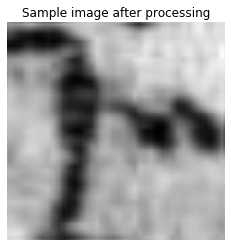

In [180]:
sample_image = my_data['File'][4]
show_image(plt.imread(sample_image),'Sample image before processing')
show_image(x_train[100],'Sample image after processing')

x_train = np.expand_dims(x_train, -1)


In [103]:

datagen = ImageDataGenerator(
 rotation_range=40,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.2,
 zoom_range=0.2,
 horizontal_flip=False)

d = datagen.fit(x_train)
x_train.shape[0]


814

In [181]:
smote = SMOTE(random_state=42)

x_smote = x_train.reshape((x_train.shape[0],x_train.shape[1]*x_train.shape[2]))

#x_smote, y_smote = smote.fit_resample(x_smote, y_train)
#x_train_

In [182]:
y_train = np.array(y_train)

In [185]:
unique, counts = np.unique(y_train, return_counts=True)
count = dict(zip(unique, counts))


In [186]:
oversample = RandomOverSampler()
x_over, y_over = oversample.fit_resample(x_smote, y_train)

In [187]:
unique, counts = np.unique(y_over, return_counts=True)
counted = dict(zip(unique, counts))
counted

{0: 49,
 28: 49,
 45: 49,
 51: 49,
 52: 49,
 53: 49,
 54: 49,
 55: 49,
 56: 49,
 57: 49,
 58: 49,
 59: 49,
 60: 49,
 61: 49,
 62: 49,
 63: 49,
 64: 49,
 66: 49,
 67: 49,
 68: 49,
 69: 49,
 70: 49,
 71: 49,
 72: 49,
 74: 49,
 75: 49,
 76: 49,
 77: 49,
 78: 49,
 79: 49,
 81: 49,
 82: 49,
 83: 49,
 84: 49,
 85: 49,
 86: 49,
 87: 49,
 88: 49,
 89: 49,
 90: 49,
 91: 49,
 92: 49,
 93: 49,
 95: 49,
 98: 49,
 99: 49,
 101: 49,
 102: 49,
 104: 49,
 105: 49,
 107: 49,
 108: 49,
 109: 49,
 110: 49,
 111: 49,
 113: 49,
 115: 49,
 117: 49,
 118: 49,
 119: 49,
 120: 49,
 121: 49,
 122: 49,
 123: 49,
 124: 49,
 125: 49,
 126: 49,
 127: 49,
 128: 49,
 132: 49,
 134: 49,
 135: 49,
 146: 49,
 148: 49,
 173: 49,
 189: 49,
 192: 49,
 193: 49,
 202: 49,
 205: 49,
 219: 49,
 246: 49,
 248: 49,
 251: 49,
 252: 49,
 253: 49,
 258: 49,
 266: 49,
 269: 49,
 270: 49,
 284: 49,
 287: 49,
 289: 49,
 292: 49,
 293: 49,
 298: 49,
 308: 49,
 311: 49,
 316: 49,
 317: 49,
 321: 49,
 324: 49,
 341: 49,
 358: 49,
 368: 4

In [188]:
#Split the training set to create a validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) 


In [189]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[224,224]))
model.add(keras.layers.Dense(300,activation="relu"))
model.add(keras.layers.Dense(100,activation="relu"))
model.add(keras.layers.Dense(4328,activation="softmax"))


model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [190]:
x_val, y_val = np.array(x_val), np.array(y_val)

In [ ]:
model.fit(x_over,y_over,epochs=30, validation_data=(x_val,y_val))

Epoch 1/30
501/501 [==============================] - 70s 139ms/step - loss: 4.1932 - accuracy: 0.2561 - val_loss: 3.5164 - val_accuracy: 0.3051
Epoch 2/30
501/501 [==============================] - 69s 137ms/step - loss: 1.0052 - accuracy: 0.7847 - val_loss: 2.2798 - val_accuracy: 0.5294
Epoch 3/30
501/501 [==============================] - 66s 132ms/step - loss: 0.5426 - accuracy: 0.8769 - val_loss: 1.8312 - val_accuracy: 0.6176
Epoch 4/30
501/501 [==============================] - 59s 117ms/step - loss: 0.3869 - accuracy: 0.9071 - val_loss: 1.6678 - val_accuracy: 0.6213
Epoch 5/30
501/501 [==============================] - 51s 102ms/step - loss: 0.3359 - accuracy: 0.9171 - val_loss: 1.3629 - val_accuracy: 0.6949
Epoch 6/30
501/501 [==============================] - 48s 97ms/step - loss: 0.3036 - accuracy: 0.9254 - val_loss: 0.9175 - val_accuracy: 0.7500
Epoch 7/30
501/501 [==============================] - 48s 96ms/step - loss: 0.2432 - accuracy: 0.9380 - val_loss: 1.6640 - val_accu

In [167]:
unique, counts = np.unique(y_val, return_counts=True)


In [168]:
counts

array([ 1,  4,  3,  3,  2,  5,  3,  5,  1,  2,  4,  2,  2,  9,  1,  2,  1,
        1,  5,  2,  6,  3,  2, 11,  9,  7, 10,  1, 10, 11,  4,  1,  3,  2,
        2,  5,  1,  3,  6,  8,  8,  3,  1,  1,  5,  5,  2,  1,  1,  1,  2,
        1,  2,  1,  1,  1,  2,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1])

In [169]:
count = dict(zip(unique, counts))

In [173]:
x = 0
for key in count:
    if count[key] ==1:
        x +=1
        print(x)
        
len(y_val)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


272

In [174]:
80/272

0.29411764705882354